In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.optim import Adam
import torchvision.transforms.functional as fn

import os
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io

from di_dataset2 import DepthImageDataset, collate_batch

from torch.utils.tensorboard import SummaryWriter

2022-02-28 14:54:28.098594: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
writer = SummaryWriter('runs/vae_cifar10')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# Load Dataset

In [3]:
saves_folders = "../../../rl_data"
load_paths = [os.path.join(saves_folders, saves_folder) for saves_folder in os.listdir(saves_folders)]

In [4]:
load_path = "../../../rl_data/saves_2"

In [5]:
tfrecord_folder='../../../rl_data/tfrecord'
tfrecord_test_folder='../../../rl_data/tfrecord/test'

In [6]:
# Hyperparams
latent_dim = 50 
num_epochs = 10
batch_size = 32
learning_rate = 1e-3

In [7]:
# Obtain train and test data
train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size)
test_dataset = DepthImageDataset(tfrecord_folder=tfrecord_test_folder, batch_size=batch_size)

Loading tfrecords...
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Done.
Loading tfrecords...
Done.


2022-02-28 14:54:28.919454: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-02-28 14:54:28.920158: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-02-28 14:54:28.921735: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-28 14:54:28.921748: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (patricknit-OptiPlex-7060): /proc/driver/nvidia/version does not exist
2022-02-28 14:54:28.921900: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate co

In [8]:
# len_train_dataset = sum(1 for _ in train_dataset) # 11223 batches (of 32)
# len_test_dataset = sum(1 for _ in test_dataset) # 1305 batches (of 32)
len_train_dataset, len_test_dataset = (69, 66) #(11223, 1305), 1 tfrecord will have varying lengths

In [9]:
# train_size = int(0.9 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=0)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=0)
# len(train_loader), len(test_loader), len(train_dataset), len(test_dataset)

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, collate_fn=collate_batch)

In [11]:
# dataiter = iter(train_loader)
# image_batch, *_ = dataiter.next() # image, height, width, depth
# image_batch.shape

In [12]:
# image_batch.squeeze().mean(), image_batch.squeeze().var()

In [13]:
def imshow(image):
    io.imshow(image.squeeze().numpy())
    io.show()

# for image in image_batch:
#     imshow(image)
    
# image.shape

# Define Variational Autoencoder


In [14]:
class VAE(nn.Module):
    def __init__(self, input_channels, feature_dim=14*27, latent_dim=500) -> None:
        super(VAE, self).__init__()
        # (input width - filter size + 2*padding)/stride + 1
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 16, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=5, stride=2),
            nn.ReLU()
        )
        
        self.fc_mu = nn.Linear(128*feature_dim, latent_dim)
        self.fc_logvar = nn.Linear(128*feature_dim, latent_dim)
        
        self.fc_z = nn.Linear(latent_dim, 128*feature_dim)
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, output_padding=(0,1)),
            nn.ReLU(),
            nn.ConvTranspose2d(16, input_channels, kernel_size=5, stride=2, output_padding=1),
            nn.ReLU(),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Inference
        x_enc = self.encoder(x)
        #print(x_enc.shape)
        x_enc = x_enc.view(-1, 128*14*27)
        
        mu = self.fc_mu(x_enc)
        logvar = self.fc_logvar(x_enc)

        # Reparametrisation
        std = torch.exp(logvar/2)
        epsilon = torch.randn_like(std) # generate eps [0,1) with dim matching std
        z = mu + std * epsilon

        # Generate
        x_hat = self.fc_z(z)
        x_hat = x_hat.view(-1, 128, 14, 27)
        x_hat = self.decoder(x_hat)
        
        return mu, logvar, x_hat
    
vae_model = VAE(input_channels=1, latent_dim=latent_dim)

In [15]:
from torchsummary import summary
summary(vae_model, (1, 270, 480))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 133, 238]             416
              ReLU-2         [-1, 16, 133, 238]               0
            Conv2d-3          [-1, 32, 65, 117]          12,832
              ReLU-4          [-1, 32, 65, 117]               0
            Conv2d-5           [-1, 64, 31, 57]          51,264
              ReLU-6           [-1, 64, 31, 57]               0
            Conv2d-7          [-1, 128, 14, 27]         204,928
              ReLU-8          [-1, 128, 14, 27]               0
            Linear-9                   [-1, 50]       2,419,250
           Linear-10                   [-1, 50]       2,419,250
           Linear-11                [-1, 48384]       2,467,584
  ConvTranspose2d-12           [-1, 64, 31, 57]         204,864
             ReLU-13           [-1, 64, 31, 57]               0
  ConvTranspose2d-14          [-1, 32, 

# Training

In [16]:
def loss_function(x, x_hat, mean, log_var):
    #reproduction_loss = nn.BCELoss(reduction='sum')(x_hat, x)
    reproduction_loss = F.binary_cross_entropy(x_hat, x, reduction="sum")
    KLD      = 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss - KLD

In [17]:
# def loss_function(x, x_hat, mu, logvar):
#     reproduction_loss = F.mse_loss(x_hat, x, reduction="sum")
#     kl_divergence = 0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

#     return reproduction_loss - kl_divergence

In [18]:
n_training_samples = len_train_dataset*32
n_iterations = math.ceil(n_training_samples/batch_size)
# n_training_samples = 399840
# n_iterations = 12495
n_training_samples, n_iterations # (399840, 12495)

(2208, 69)

In [19]:
vae_model = VAE(input_channels=1, latent_dim=latent_dim)
optimiser = torch.optim.Adam(vae_model.parameters(), lr=learning_rate)

Loading tfrecords...
Done.


2022-02-28 14:54:29.235313: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-02-28 14:54:29.253130: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3199980000 Hz


Epoch: 1/10, Step: 1, Avg loss: 89458.625, time: 1.42, Avg. per iter 1.08


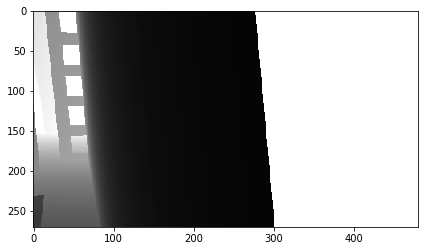

/home/patricknit/anaconda3/envs/tf_gpu/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


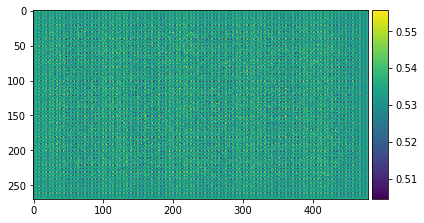

Epoch: 1/10, Step: 2, Avg loss: 89311.859, time: 2.73, Avg. per iter 1.06
Epoch: 1/10, Step: 3, Avg loss: 89726.469, time: 3.79, Avg. per iter 1.06
Epoch: 1/10, Step: 4, Avg loss: 89704.516, time: 4.82, Avg. per iter 1.05
Epoch: 1/10, Step: 5, Avg loss: 89894.992, time: 5.94, Avg. per iter 1.06
Epoch: 1/10, Step: 6, Avg loss: 89792.844, time: 6.92, Avg. per iter 1.05
Epoch: 1/10, Step: 7, Avg loss: 89572.727, time: 7.98, Avg. per iter 1.05
Epoch: 1/10, Step: 8, Avg loss: 89547.242, time: 9.03, Avg. per iter 1.05
Epoch: 1/10, Step: 9, Avg loss: 89525.492, time: 10.04, Avg. per iter 1.05
Epoch: 1/10, Step: 10, Avg loss: 89253.211, time: 11.03, Avg. per iter 1.04
Epoch: 1/10, Step: 11, Avg loss: 88904.742, time: 12.01, Avg. per iter 1.03
Epoch: 1/10, Step: 12, Avg loss: 88567.461, time: 12.98, Avg. per iter 1.03
Epoch: 1/10, Step: 13, Avg loss: 88304.789, time: 13.96, Avg. per iter 1.03
Epoch: 1/10, Step: 14, Avg loss: 88097.562, time: 14.94, Avg. per iter 1.02
Epoch: 1/10, Step: 15, Avg 

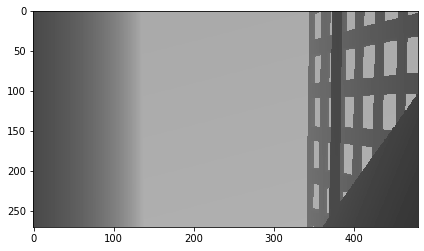

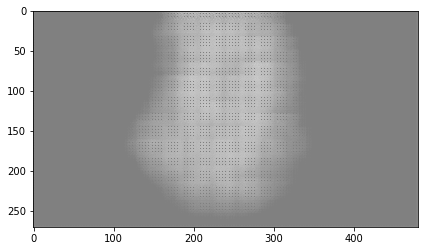

Epoch: 2/10, Step: 2, Avg loss: 76443.484, time: 2.49, Avg. per iter 1.02
Epoch: 2/10, Step: 3, Avg loss: 78202.195, time: 3.46, Avg. per iter 1.02
Epoch: 2/10, Step: 4, Avg loss: 78930.938, time: 4.42, Avg. per iter 1.02
Epoch: 2/10, Step: 5, Avg loss: 78373.422, time: 5.38, Avg. per iter 1.02
Epoch: 2/10, Step: 6, Avg loss: 78829.398, time: 6.35, Avg. per iter 1.02
Epoch: 2/10, Step: 7, Avg loss: 78873.047, time: 7.36, Avg. per iter 1.02
Epoch: 2/10, Step: 8, Avg loss: 79650.680, time: 8.40, Avg. per iter 1.02
Epoch: 2/10, Step: 9, Avg loss: 79643.000, time: 9.37, Avg. per iter 1.02
Epoch: 2/10, Step: 10, Avg loss: 79602.609, time: 10.51, Avg. per iter 1.02
Epoch: 2/10, Step: 11, Avg loss: 79752.445, time: 11.57, Avg. per iter 1.02
Epoch: 2/10, Step: 12, Avg loss: 79242.523, time: 12.54, Avg. per iter 1.02
Epoch: 2/10, Step: 13, Avg loss: 79230.211, time: 13.51, Avg. per iter 1.02
Epoch: 2/10, Step: 14, Avg loss: 79183.328, time: 14.51, Avg. per iter 1.02
Epoch: 2/10, Step: 15, Avg l

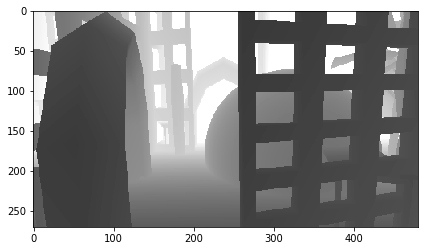

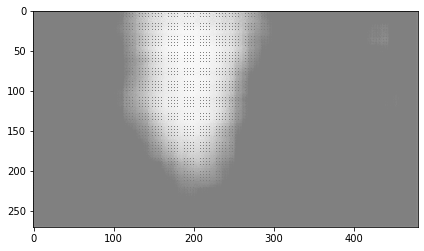

Epoch: 3/10, Step: 2, Avg loss: 77413.281, time: 2.83, Avg. per iter 1.03
Epoch: 3/10, Step: 3, Avg loss: 78277.250, time: 3.88, Avg. per iter 1.03
Epoch: 3/10, Step: 4, Avg loss: 77096.781, time: 5.10, Avg. per iter 1.03
Epoch: 3/10, Step: 5, Avg loss: 75818.039, time: 6.15, Avg. per iter 1.03
Epoch: 3/10, Step: 6, Avg loss: 76816.508, time: 7.15, Avg. per iter 1.03
Epoch: 3/10, Step: 7, Avg loss: 77690.789, time: 8.26, Avg. per iter 1.03
Epoch: 3/10, Step: 8, Avg loss: 77128.625, time: 9.38, Avg. per iter 1.03
Epoch: 3/10, Step: 9, Avg loss: 77724.094, time: 10.41, Avg. per iter 1.03
Epoch: 3/10, Step: 10, Avg loss: 77515.828, time: 11.60, Avg. per iter 1.03
Epoch: 3/10, Step: 11, Avg loss: 77206.555, time: 12.81, Avg. per iter 1.03
Epoch: 3/10, Step: 12, Avg loss: 76786.438, time: 13.89, Avg. per iter 1.03
Epoch: 3/10, Step: 13, Avg loss: 77047.945, time: 14.90, Avg. per iter 1.03
Epoch: 3/10, Step: 14, Avg loss: 76752.586, time: 16.05, Avg. per iter 1.03
Epoch: 3/10, Step: 15, Avg 

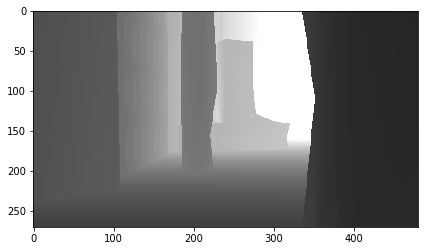

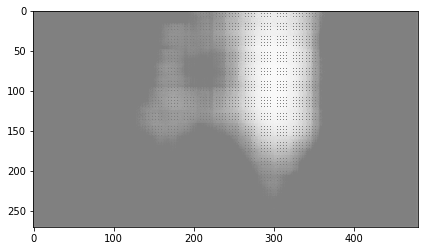

Epoch: 4/10, Step: 2, Avg loss: 76027.523, time: 2.39, Avg. per iter 1.04
Epoch: 4/10, Step: 3, Avg loss: 74332.289, time: 3.39, Avg. per iter 1.04
Epoch: 4/10, Step: 4, Avg loss: 74203.734, time: 4.41, Avg. per iter 1.04
Epoch: 4/10, Step: 5, Avg loss: 74609.648, time: 5.41, Avg. per iter 1.04
Epoch: 4/10, Step: 6, Avg loss: 74291.227, time: 6.50, Avg. per iter 1.04
Epoch: 4/10, Step: 7, Avg loss: 74382.953, time: 7.59, Avg. per iter 1.04
Epoch: 4/10, Step: 8, Avg loss: 74879.188, time: 8.59, Avg. per iter 1.04
Epoch: 4/10, Step: 9, Avg loss: 74403.414, time: 9.58, Avg. per iter 1.04
Epoch: 4/10, Step: 10, Avg loss: 74995.422, time: 10.51, Avg. per iter 1.04
Epoch: 4/10, Step: 11, Avg loss: 74548.445, time: 11.46, Avg. per iter 1.04
Epoch: 4/10, Step: 12, Avg loss: 74726.680, time: 12.44, Avg. per iter 1.04
Epoch: 4/10, Step: 13, Avg loss: 75034.070, time: 13.41, Avg. per iter 1.04
Epoch: 4/10, Step: 14, Avg loss: 75213.047, time: 14.38, Avg. per iter 1.04
Epoch: 4/10, Step: 15, Avg l

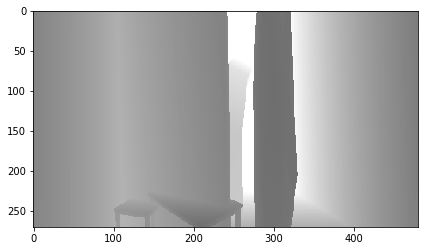

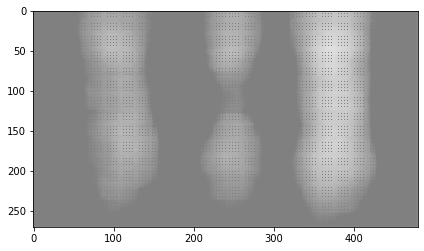

Epoch: 5/10, Step: 2, Avg loss: 76403.109, time: 2.33, Avg. per iter 1.02
Epoch: 5/10, Step: 3, Avg loss: 76978.742, time: 3.28, Avg. per iter 1.02
Epoch: 5/10, Step: 4, Avg loss: 77928.641, time: 4.29, Avg. per iter 1.02
Epoch: 5/10, Step: 5, Avg loss: 77475.711, time: 5.26, Avg. per iter 1.02
Epoch: 5/10, Step: 6, Avg loss: 77150.984, time: 6.21, Avg. per iter 1.02
Epoch: 5/10, Step: 7, Avg loss: 76818.477, time: 7.16, Avg. per iter 1.02
Epoch: 5/10, Step: 8, Avg loss: 76770.242, time: 8.11, Avg. per iter 1.02
Epoch: 5/10, Step: 9, Avg loss: 76159.539, time: 9.05, Avg. per iter 1.02
Epoch: 5/10, Step: 10, Avg loss: 76482.070, time: 10.00, Avg. per iter 1.02
Epoch: 5/10, Step: 11, Avg loss: 76372.469, time: 10.94, Avg. per iter 1.02
Epoch: 5/10, Step: 12, Avg loss: 76248.336, time: 11.88, Avg. per iter 1.02
Epoch: 5/10, Step: 13, Avg loss: 76135.336, time: 12.82, Avg. per iter 1.02
Epoch: 5/10, Step: 14, Avg loss: 75837.984, time: 13.77, Avg. per iter 1.02
Epoch: 5/10, Step: 15, Avg l

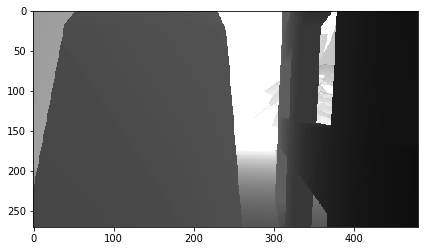

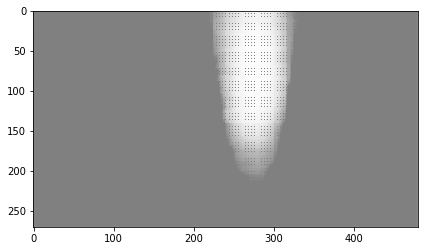

Epoch: 6/10, Step: 2, Avg loss: 71315.938, time: 2.41, Avg. per iter 1.01
Epoch: 6/10, Step: 3, Avg loss: 72777.195, time: 3.35, Avg. per iter 1.01
Epoch: 6/10, Step: 4, Avg loss: 71189.414, time: 4.30, Avg. per iter 1.01
Epoch: 6/10, Step: 5, Avg loss: 72295.172, time: 5.27, Avg. per iter 1.01
Epoch: 6/10, Step: 6, Avg loss: 72986.320, time: 6.22, Avg. per iter 1.01
Epoch: 6/10, Step: 7, Avg loss: 73635.008, time: 7.17, Avg. per iter 1.01
Epoch: 6/10, Step: 8, Avg loss: 74077.109, time: 8.11, Avg. per iter 1.01
Epoch: 6/10, Step: 9, Avg loss: 74367.547, time: 9.05, Avg. per iter 1.01
Epoch: 6/10, Step: 10, Avg loss: 74156.844, time: 9.99, Avg. per iter 1.01
Epoch: 6/10, Step: 11, Avg loss: 74386.336, time: 10.93, Avg. per iter 1.01
Epoch: 6/10, Step: 12, Avg loss: 74825.695, time: 11.88, Avg. per iter 1.01
Epoch: 6/10, Step: 13, Avg loss: 75063.078, time: 12.82, Avg. per iter 1.01
Epoch: 6/10, Step: 14, Avg loss: 75129.711, time: 13.76, Avg. per iter 1.01
Epoch: 6/10, Step: 15, Avg lo

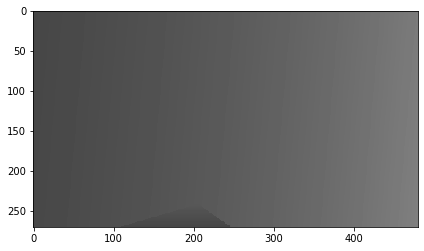

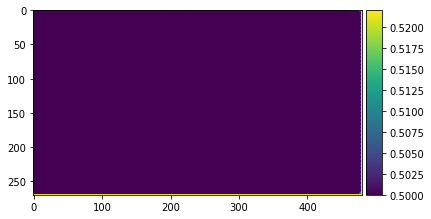

Epoch: 7/10, Step: 2, Avg loss: 73733.219, time: 2.41, Avg. per iter 1.00
Epoch: 7/10, Step: 3, Avg loss: 72807.141, time: 3.38, Avg. per iter 1.00
Epoch: 7/10, Step: 4, Avg loss: 74058.445, time: 4.35, Avg. per iter 1.00
Epoch: 7/10, Step: 5, Avg loss: 74575.625, time: 5.33, Avg. per iter 1.00
Epoch: 7/10, Step: 6, Avg loss: 74865.094, time: 6.28, Avg. per iter 1.00
Epoch: 7/10, Step: 7, Avg loss: 75279.484, time: 7.23, Avg. per iter 1.00
Epoch: 7/10, Step: 8, Avg loss: 75231.680, time: 8.18, Avg. per iter 1.00
Epoch: 7/10, Step: 9, Avg loss: 75559.203, time: 9.13, Avg. per iter 1.00
Epoch: 7/10, Step: 10, Avg loss: 75596.609, time: 10.08, Avg. per iter 1.00
Epoch: 7/10, Step: 11, Avg loss: 75872.539, time: 11.02, Avg. per iter 1.00
Epoch: 7/10, Step: 12, Avg loss: 75320.297, time: 11.97, Avg. per iter 1.00
Epoch: 7/10, Step: 13, Avg loss: 75331.344, time: 12.91, Avg. per iter 1.00
Epoch: 7/10, Step: 14, Avg loss: 75091.367, time: 13.87, Avg. per iter 1.00
Epoch: 7/10, Step: 15, Avg l

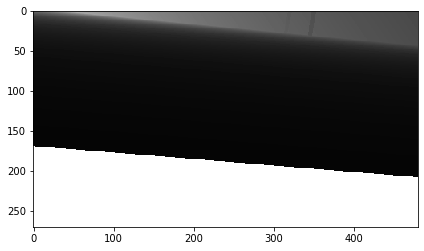

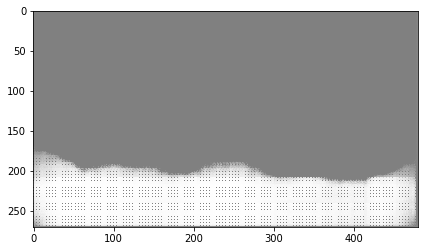

Epoch: 8/10, Step: 2, Avg loss: 80402.055, time: 2.53, Avg. per iter 1.00
Epoch: 8/10, Step: 3, Avg loss: 80338.531, time: 3.51, Avg. per iter 1.00
Epoch: 8/10, Step: 4, Avg loss: 79410.688, time: 4.49, Avg. per iter 1.00
Epoch: 8/10, Step: 5, Avg loss: 79218.211, time: 5.48, Avg. per iter 1.00
Epoch: 8/10, Step: 6, Avg loss: 79001.453, time: 6.42, Avg. per iter 1.00
Epoch: 8/10, Step: 7, Avg loss: 79071.625, time: 7.35, Avg. per iter 1.00
Epoch: 8/10, Step: 8, Avg loss: 78936.938, time: 8.30, Avg. per iter 1.00
Epoch: 8/10, Step: 9, Avg loss: 79301.102, time: 9.24, Avg. per iter 1.00
Epoch: 8/10, Step: 10, Avg loss: 78870.750, time: 10.19, Avg. per iter 1.00
Epoch: 8/10, Step: 11, Avg loss: 78477.688, time: 11.18, Avg. per iter 1.00
Epoch: 8/10, Step: 12, Avg loss: 78440.133, time: 12.15, Avg. per iter 1.00
Epoch: 8/10, Step: 13, Avg loss: 78411.234, time: 13.14, Avg. per iter 1.00
Epoch: 8/10, Step: 14, Avg loss: 78646.367, time: 14.12, Avg. per iter 0.99
Epoch: 8/10, Step: 15, Avg l

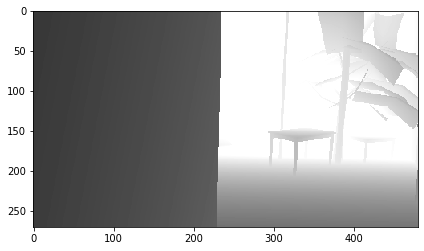

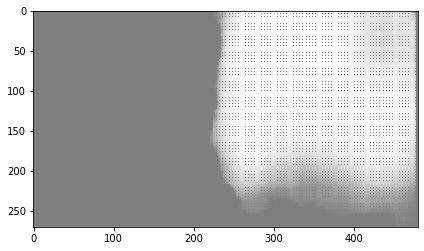

Epoch: 9/10, Step: 2, Avg loss: 75209.328, time: 2.38, Avg. per iter 0.99
Epoch: 9/10, Step: 3, Avg loss: 77070.039, time: 3.32, Avg. per iter 0.99
Epoch: 9/10, Step: 4, Avg loss: 74483.773, time: 4.28, Avg. per iter 0.99
Epoch: 9/10, Step: 5, Avg loss: 73772.086, time: 5.22, Avg. per iter 0.99
Epoch: 9/10, Step: 6, Avg loss: 74158.414, time: 6.16, Avg. per iter 0.99
Epoch: 9/10, Step: 7, Avg loss: 74204.875, time: 7.10, Avg. per iter 0.99
Epoch: 9/10, Step: 8, Avg loss: 74854.664, time: 8.04, Avg. per iter 0.99
Epoch: 9/10, Step: 9, Avg loss: 74737.531, time: 8.98, Avg. per iter 0.99
Epoch: 9/10, Step: 10, Avg loss: 75117.391, time: 9.96, Avg. per iter 0.99
Epoch: 9/10, Step: 11, Avg loss: 75006.930, time: 10.93, Avg. per iter 0.99
Epoch: 9/10, Step: 12, Avg loss: 75243.266, time: 11.88, Avg. per iter 0.99
Epoch: 9/10, Step: 13, Avg loss: 75110.219, time: 12.82, Avg. per iter 0.99
Epoch: 9/10, Step: 14, Avg loss: 75318.188, time: 13.76, Avg. per iter 0.99
Epoch: 9/10, Step: 15, Avg lo

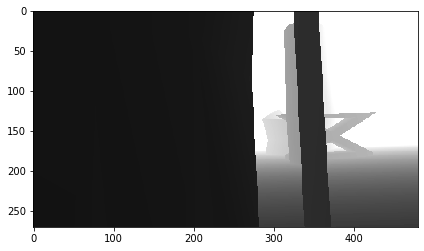

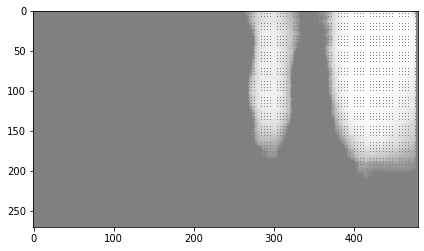

Epoch: 10/10, Step: 2, Avg loss: 75136.266, time: 2.41, Avg. per iter 0.99
Epoch: 10/10, Step: 3, Avg loss: 75588.195, time: 3.39, Avg. per iter 0.99
Epoch: 10/10, Step: 4, Avg loss: 76266.117, time: 4.34, Avg. per iter 0.99
Epoch: 10/10, Step: 5, Avg loss: 76188.109, time: 5.29, Avg. per iter 0.99
Epoch: 10/10, Step: 6, Avg loss: 76419.375, time: 6.24, Avg. per iter 0.99
Epoch: 10/10, Step: 7, Avg loss: 76875.484, time: 7.18, Avg. per iter 0.99
Epoch: 10/10, Step: 8, Avg loss: 76413.016, time: 8.12, Avg. per iter 0.99
Epoch: 10/10, Step: 9, Avg loss: 76975.594, time: 9.07, Avg. per iter 0.99
Epoch: 10/10, Step: 10, Avg loss: 76276.195, time: 10.02, Avg. per iter 0.99
Epoch: 10/10, Step: 11, Avg loss: 76087.289, time: 10.97, Avg. per iter 0.99
Epoch: 10/10, Step: 12, Avg loss: 76047.359, time: 11.90, Avg. per iter 0.99
Epoch: 10/10, Step: 13, Avg loss: 76232.781, time: 12.84, Avg. per iter 0.99
Epoch: 10/10, Step: 14, Avg loss: 76179.055, time: 13.79, Avg. per iter 0.99
Epoch: 10/10, S

In [20]:
time_iteration = []

for epoch in range(num_epochs):
    overall_loss = 0
    since = time.time()
    train_dataset = DepthImageDataset(tfrecord_folder=tfrecord_folder, batch_size=batch_size) # 176 tfrecords
    train_loader = DataLoader(dataset=train_dataset, batch_size=1, collate_fn=collate_batch)
    
    for i, (image, *_) in enumerate(train_loader):
        since_iter = time.time()

        optimiser.zero_grad()

        # VAE forward pass
        mu, logvar, x_hat = vae_model(image)

        # Loss
        loss = loss_function(image, x_hat, mu, logvar)

        overall_loss += loss

        # Update weights
        loss.backward()
        optimiser.step()

        time_iteration.append(time.time() - since_iter)
        iter_time_mean = np.array(time_iteration).mean()
        
        if (i+1) % 1 == 0:
            time_elapsed = time.time() - since
            print(f"Epoch: {epoch+1}/{num_epochs}, Step: {i+1}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter {iter_time_mean:.2f}")
            #print(f"Epoch: {epoch+1}/{num_epochs}, Step: {i+1}/{n_iterations}, Avg loss: {overall_loss/((i+1)*batch_size):.3f}, time: {time_elapsed:.2f}, Avg. per iter {iter_time_mean:.2f}, Est. time left {iter_time_mean*(n_iterations - (i+1)):.2f}")
    
        if i == 0:
            imshow(image[0])
            imshow(x_hat[0].detach())    
            print(f"image mean: {image[0].mean()}, var: {image[0].var()}")
            print(f"x_hat mean: {x_hat[0].mean()}, var: {x_hat[0].var()}")
    


# Evaluate

## Test set

tensor(0.5261) tensor(0.6510)
tensor(0.1123) tensor(0.0379)
torch.Size([32, 1, 270, 480])


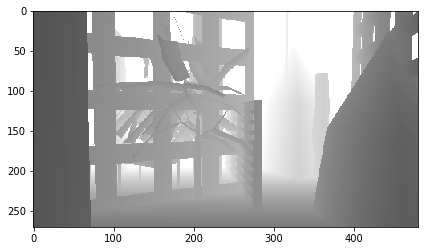

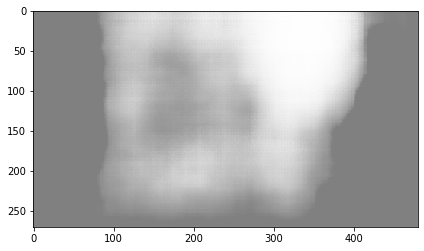

i: 0
tensor(0.5405) tensor(0.6526)
tensor(0.1046) tensor(0.0378)
torch.Size([32, 1, 270, 480])


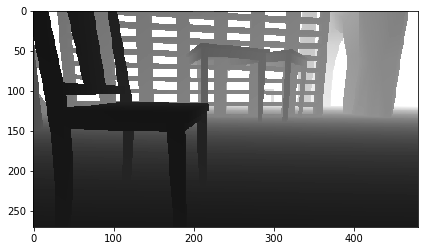

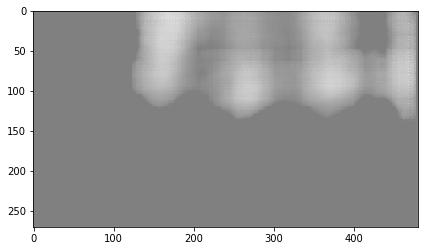

i: 1
tensor(0.4973) tensor(0.6471)
tensor(0.1168) tensor(0.0388)
torch.Size([32, 1, 270, 480])


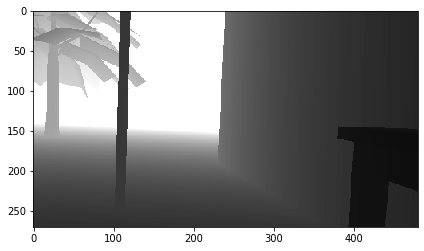

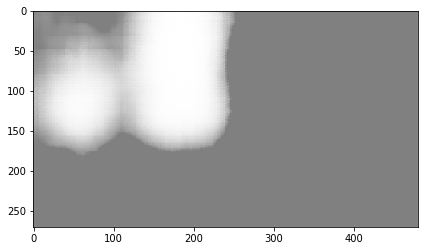

i: 2
tensor(0.5257) tensor(0.6604)
tensor(0.1172) tensor(0.0424)
torch.Size([32, 1, 270, 480])


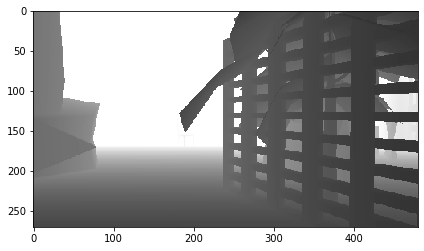

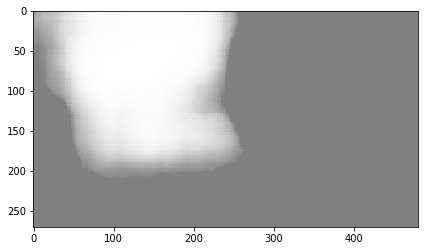

i: 3
tensor(0.5043) tensor(0.6507)
tensor(0.1213) tensor(0.0415)
torch.Size([32, 1, 270, 480])


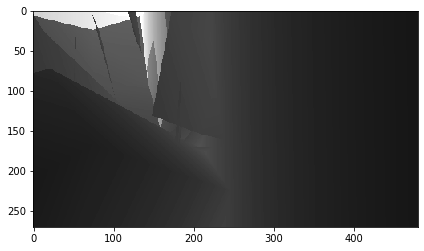

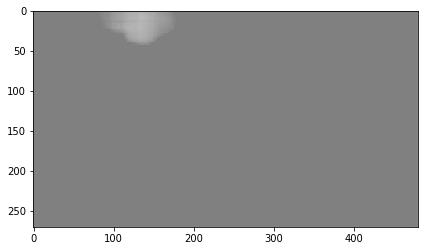

i: 4
tensor(0.5378) tensor(0.6414)
tensor(0.0901) tensor(0.0377)
torch.Size([32, 1, 270, 480])


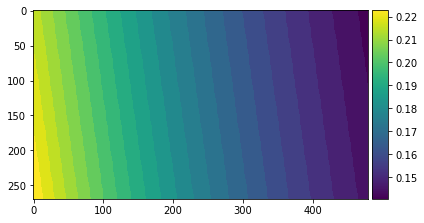

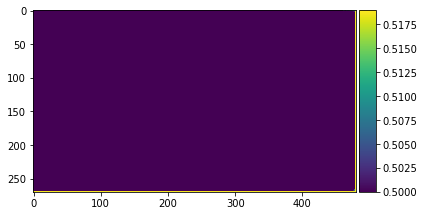

i: 5
tensor(0.4922) tensor(0.6417)
tensor(0.1174) tensor(0.0378)
torch.Size([32, 1, 270, 480])


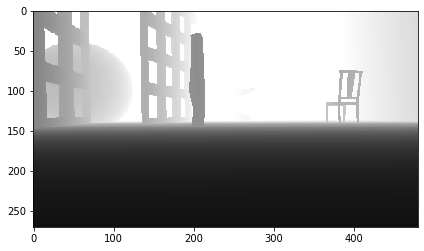

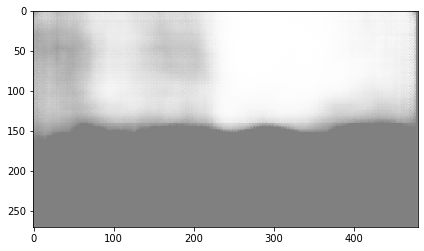

i: 6
tensor(0.4901) tensor(0.6366)
tensor(0.1137) tensor(0.0374)
torch.Size([32, 1, 270, 480])


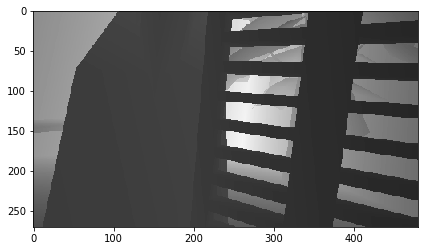

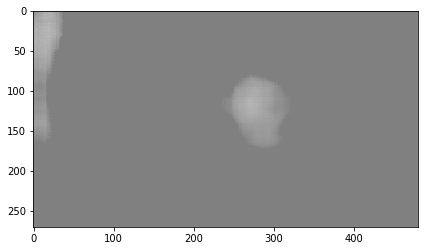

i: 7
tensor(0.4618) tensor(0.6261)
tensor(0.1167) tensor(0.0363)
torch.Size([32, 1, 270, 480])


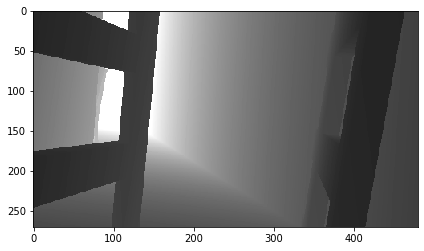

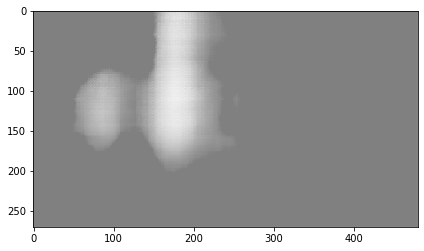

i: 8
tensor(0.4816) tensor(0.6318)
tensor(0.1111) tensor(0.0355)
torch.Size([32, 1, 270, 480])


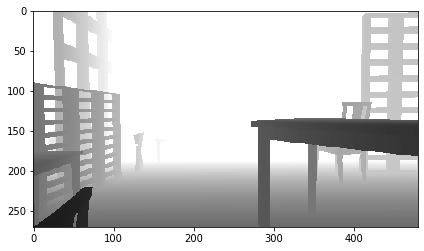

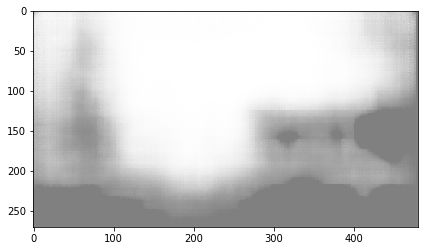

i: 9
tensor(0.4399) tensor(0.6123)
tensor(0.1110) tensor(0.0323)
torch.Size([32, 1, 270, 480])


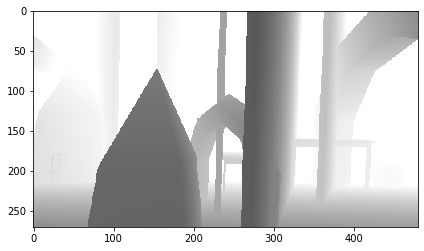

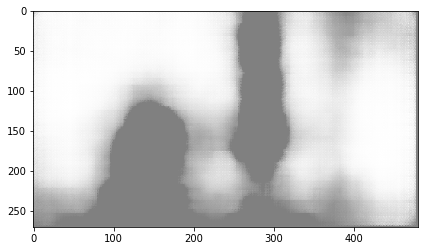

i: 10
tensor(0.4469) tensor(0.6024)
tensor(0.0935) tensor(0.0298)
torch.Size([32, 1, 270, 480])


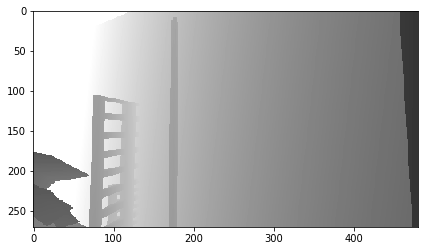

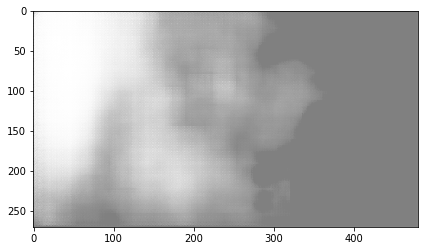

i: 11
tensor(0.5367) tensor(0.6603)
tensor(0.1158) tensor(0.0405)
torch.Size([32, 1, 270, 480])


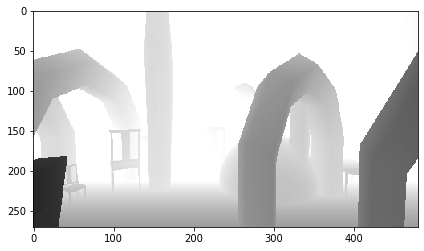

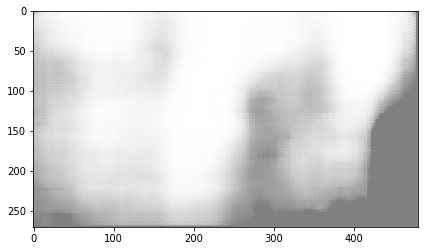

i: 12
tensor(0.5040) tensor(0.6463)
tensor(0.1194) tensor(0.0405)
torch.Size([32, 1, 270, 480])


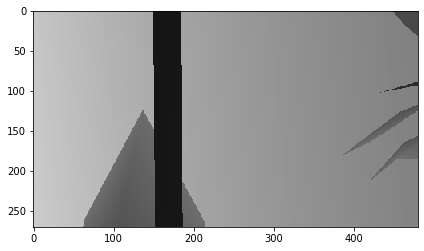

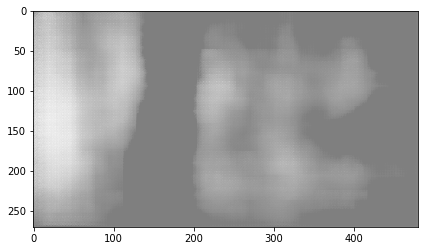

i: 13
tensor(0.5055) tensor(0.6435)
tensor(0.1127) tensor(0.0368)
torch.Size([32, 1, 270, 480])


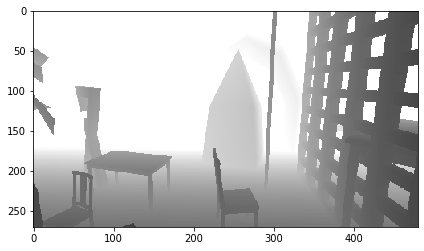

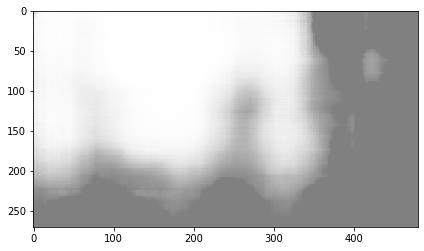

i: 14
tensor(0.4822) tensor(0.6400)
tensor(0.1230) tensor(0.0383)
torch.Size([32, 1, 270, 480])


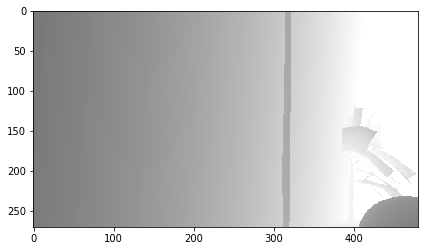

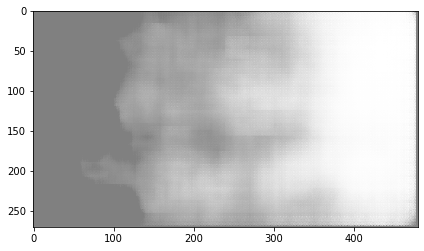

i: 15
tensor(0.5458) tensor(0.6650)
tensor(0.1116) tensor(0.0384)
torch.Size([32, 1, 270, 480])


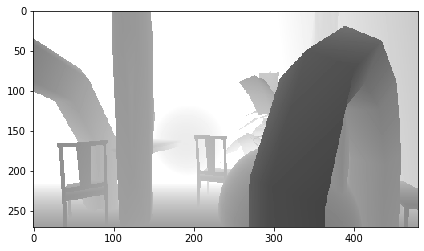

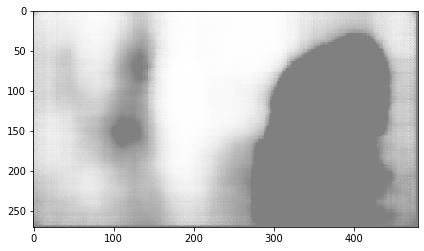

i: 16
tensor(0.5084) tensor(0.6338)
tensor(0.1050) tensor(0.0352)
torch.Size([32, 1, 270, 480])


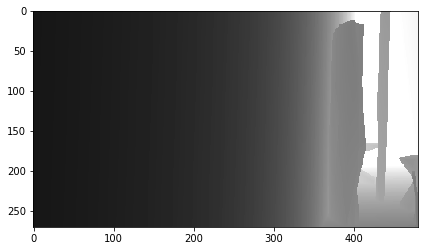

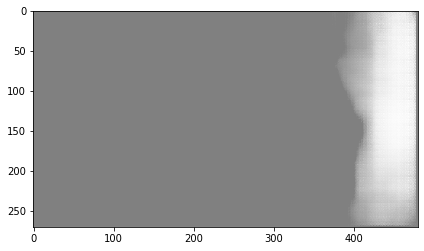

i: 17
tensor(0.5434) tensor(0.6520)
tensor(0.1036) tensor(0.0378)
torch.Size([32, 1, 270, 480])


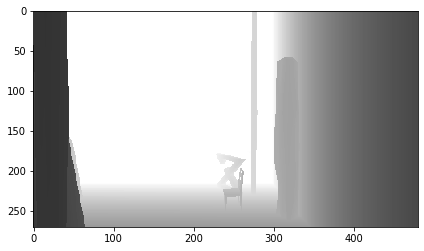

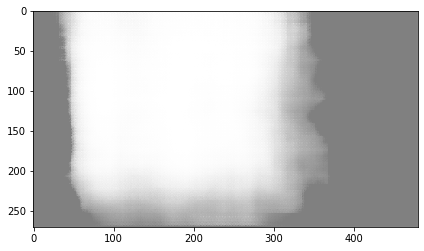

i: 18
tensor(0.4744) tensor(0.6252)
tensor(0.1065) tensor(0.0351)
torch.Size([32, 1, 270, 480])


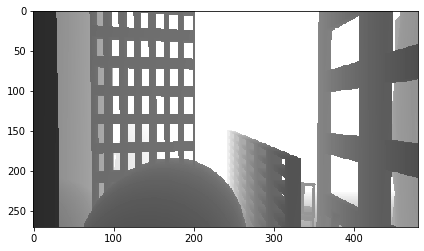

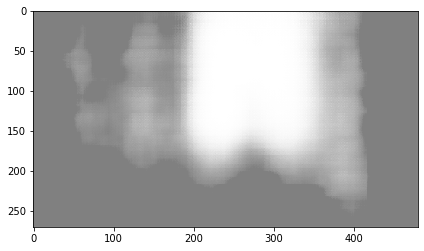

i: 19
tensor(0.5175) tensor(0.6452)
tensor(0.1093) tensor(0.0376)
torch.Size([32, 1, 270, 480])


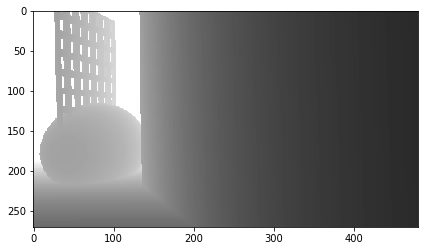

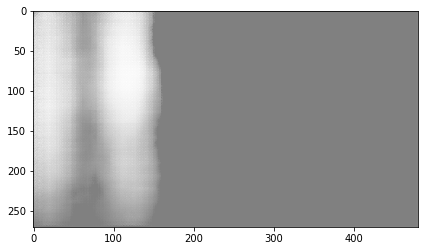

i: 20
tensor(0.5469) tensor(0.6595)
tensor(0.1089) tensor(0.0395)
torch.Size([32, 1, 270, 480])


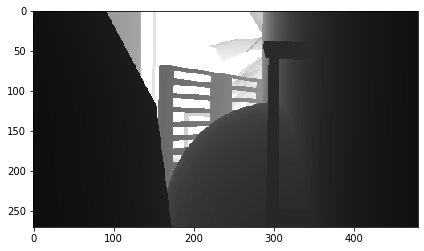

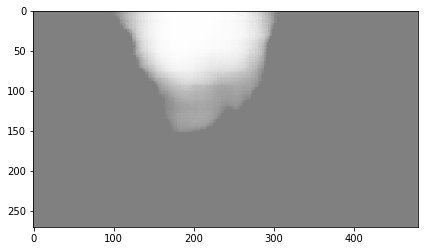

i: 21
tensor(0.4478) tensor(0.6075)
tensor(0.1016) tensor(0.0317)
torch.Size([32, 1, 270, 480])


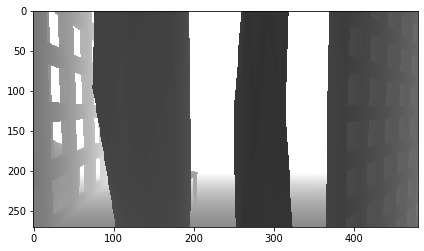

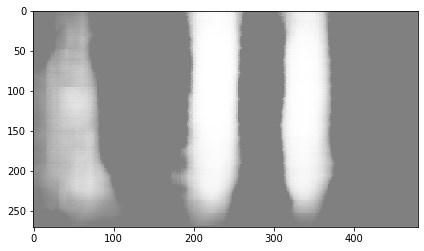

i: 22
tensor(0.5203) tensor(0.6445)
tensor(0.1051) tensor(0.0352)
torch.Size([32, 1, 270, 480])


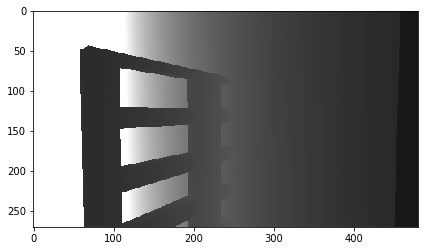

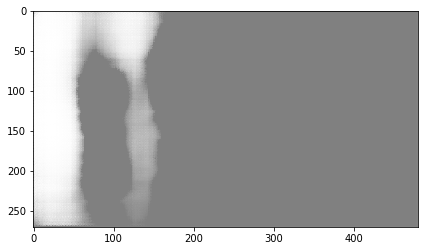

i: 23
tensor(0.4813) tensor(0.6313)
tensor(0.1124) tensor(0.0359)
torch.Size([32, 1, 270, 480])


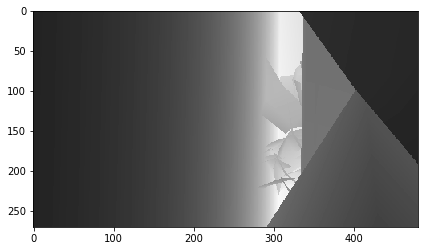

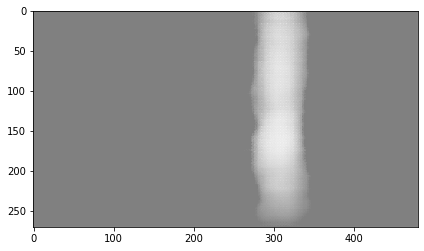

i: 24
tensor(0.4115) tensor(0.5876)
tensor(0.0929) tensor(0.0255)
torch.Size([32, 1, 270, 480])


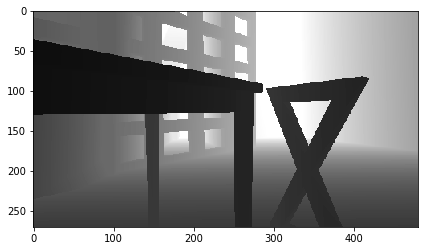

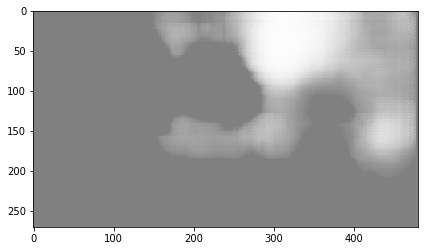

i: 25
tensor(0.5032) tensor(0.6325)
tensor(0.1058) tensor(0.0355)
torch.Size([32, 1, 270, 480])


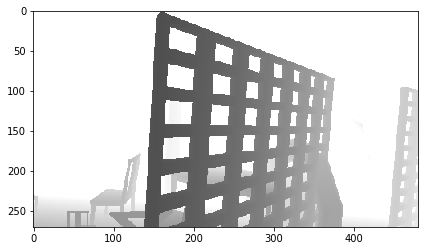

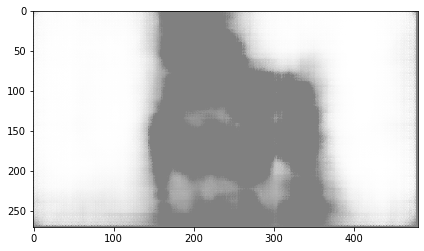

i: 26
tensor(0.5210) tensor(0.6370)
tensor(0.0987) tensor(0.0349)
torch.Size([32, 1, 270, 480])


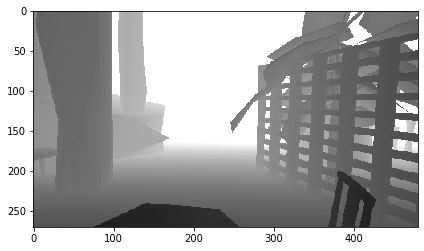

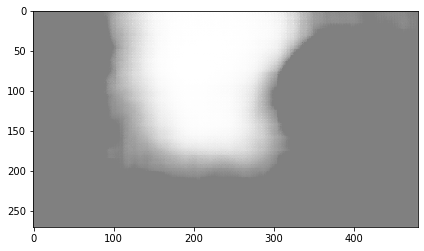

i: 27
tensor(0.4327) tensor(0.6015)
tensor(0.1016) tensor(0.0284)
torch.Size([32, 1, 270, 480])


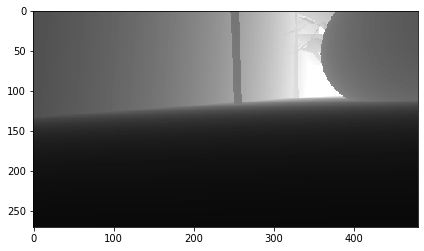

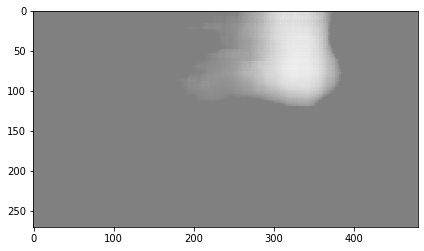

i: 28
tensor(0.4693) tensor(0.6366)
tensor(0.1232) tensor(0.0401)
torch.Size([32, 1, 270, 480])


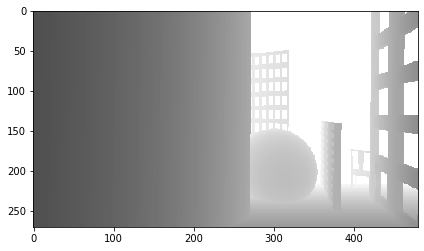

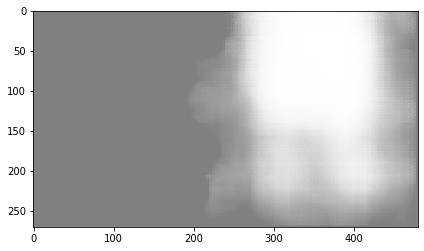

i: 29
tensor(0.4475) tensor(0.6075)
tensor(0.1008) tensor(0.0305)
torch.Size([32, 1, 270, 480])


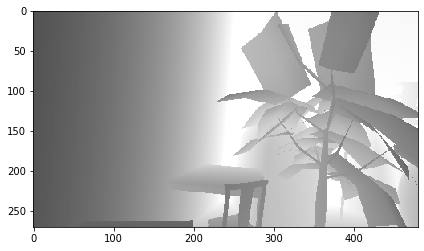

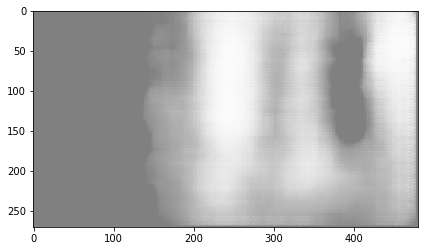

i: 30
tensor(0.4422) tensor(0.6178)
tensor(0.1129) tensor(0.0328)
torch.Size([32, 1, 270, 480])


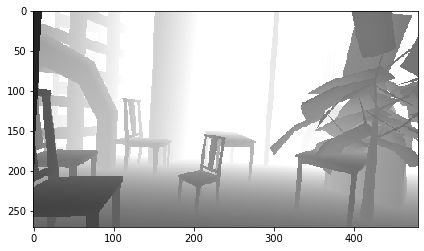

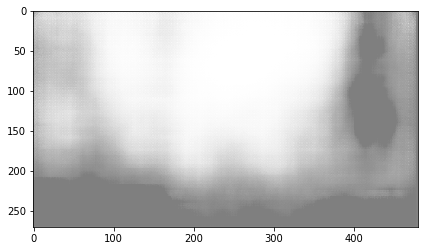

i: 31
tensor(0.5182) tensor(0.6585)
tensor(0.1303) tensor(0.0411)
torch.Size([32, 1, 270, 480])


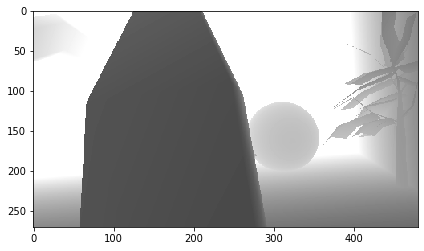

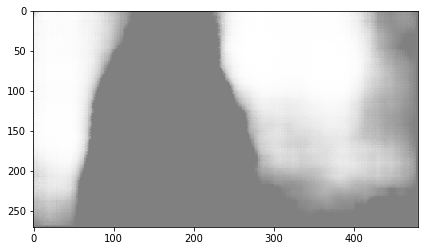

i: 32
tensor(0.5505) tensor(0.6596)
tensor(0.1035) tensor(0.0396)
torch.Size([32, 1, 270, 480])


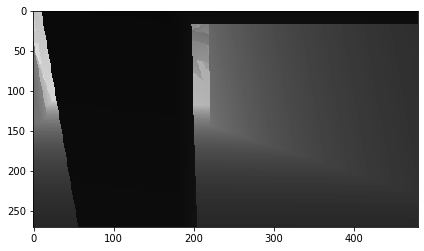

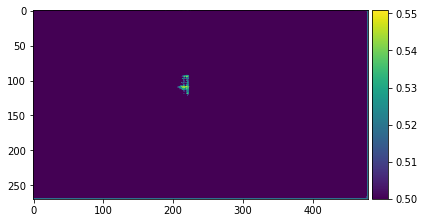

i: 33
tensor(0.5166) tensor(0.6436)
tensor(0.1073) tensor(0.0379)
torch.Size([32, 1, 270, 480])


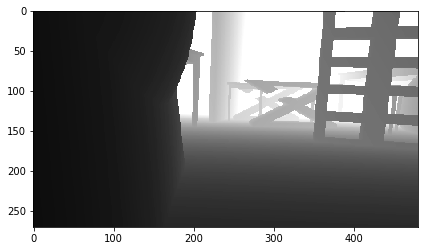

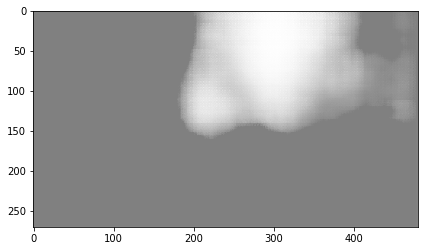

i: 34
tensor(0.4970) tensor(0.6437)
tensor(0.1221) tensor(0.0389)
torch.Size([32, 1, 270, 480])


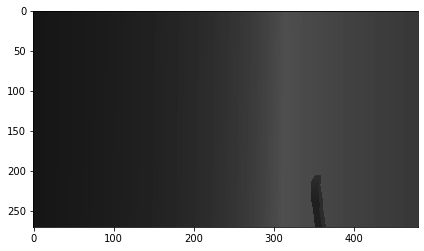

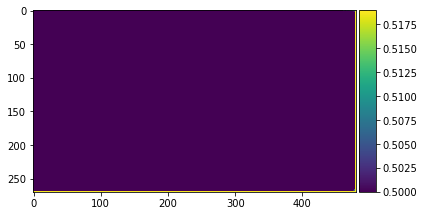

i: 35
tensor(0.4755) tensor(0.6206)
tensor(0.1021) tensor(0.0323)
torch.Size([32, 1, 270, 480])


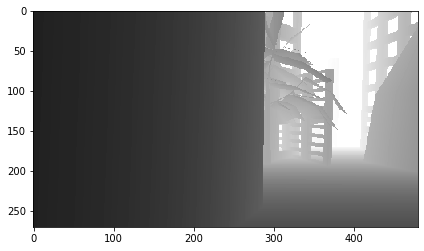

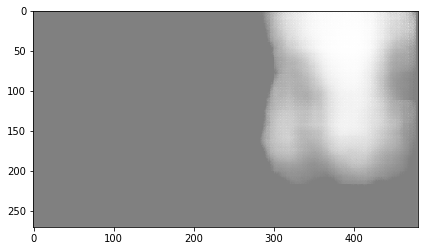

i: 36
tensor(0.4507) tensor(0.6144)
tensor(0.1053) tensor(0.0324)
torch.Size([32, 1, 270, 480])


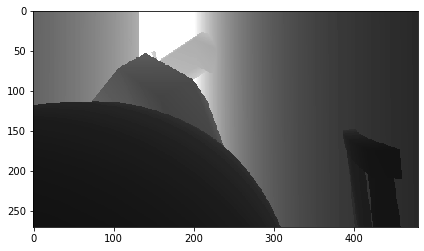

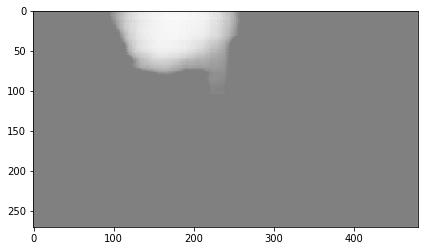

i: 37
tensor(0.4744) tensor(0.6273)
tensor(0.1141) tensor(0.0348)
torch.Size([32, 1, 270, 480])


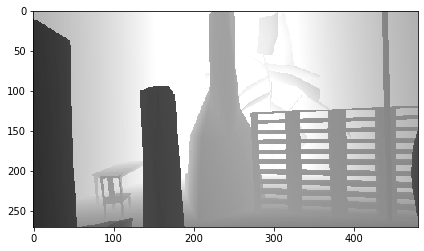

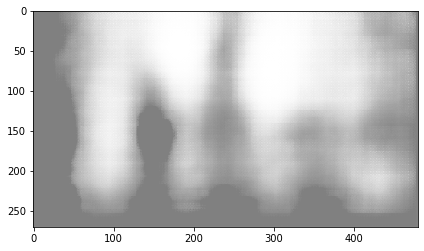

i: 38
tensor(0.5487) tensor(0.6702)
tensor(0.1286) tensor(0.0423)
torch.Size([32, 1, 270, 480])


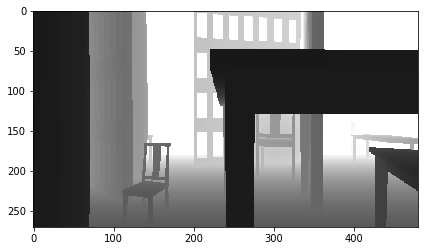

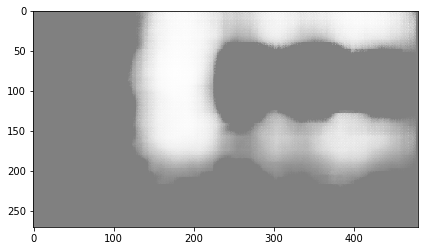

i: 39
tensor(0.5069) tensor(0.6432)
tensor(0.1108) tensor(0.0363)
torch.Size([32, 1, 270, 480])


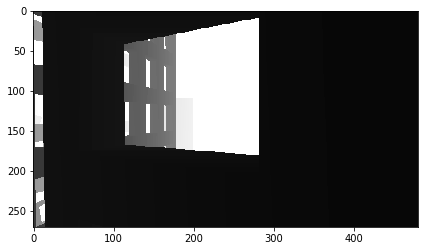

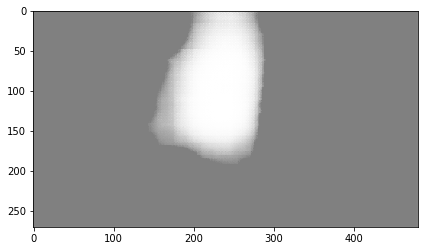

i: 40
tensor(0.5334) tensor(0.6544)
tensor(0.1145) tensor(0.0406)
torch.Size([32, 1, 270, 480])


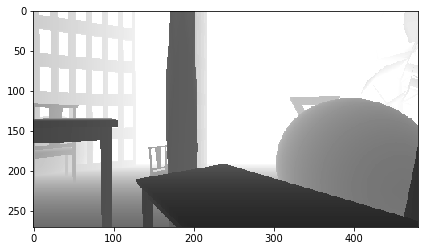

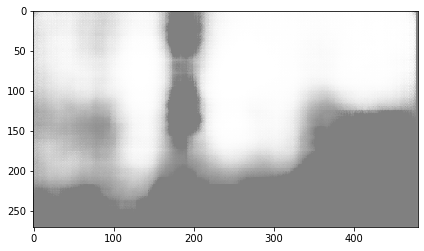

i: 41
tensor(0.5496) tensor(0.6639)
tensor(0.1145) tensor(0.0422)
torch.Size([32, 1, 270, 480])


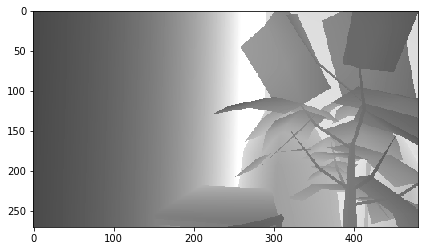

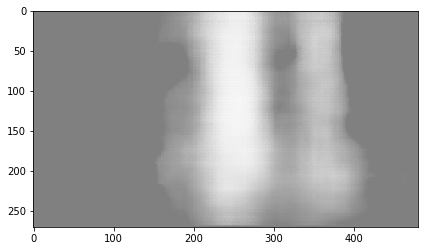

i: 42
tensor(0.4470) tensor(0.6315)
tensor(0.1290) tensor(0.0370)
torch.Size([32, 1, 270, 480])


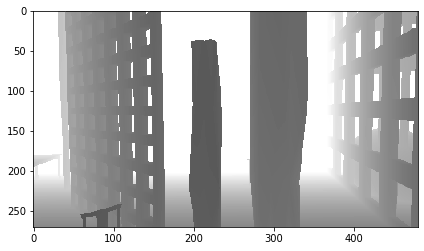

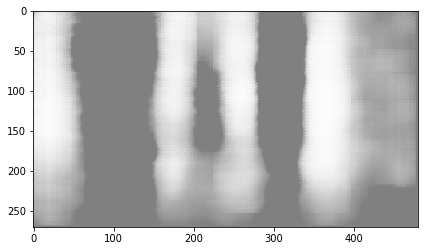

i: 43
tensor(0.4205) tensor(0.5950)
tensor(0.0953) tensor(0.0264)
torch.Size([32, 1, 270, 480])


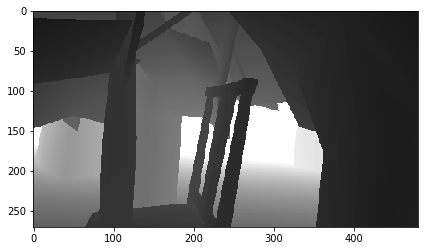

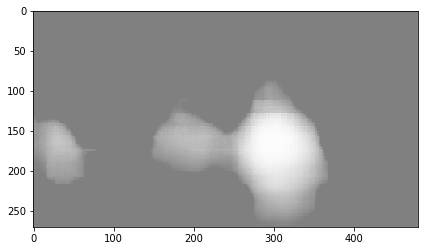

i: 44
tensor(0.4740) tensor(0.6292)
tensor(0.1202) tensor(0.0345)
torch.Size([32, 1, 270, 480])


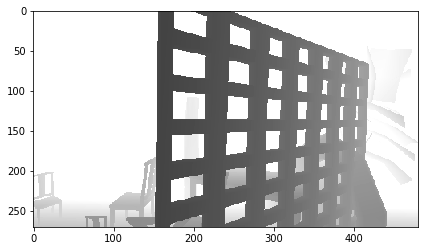

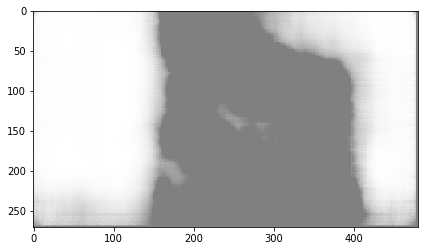

i: 45
tensor(0.5537) tensor(0.6507)
tensor(0.0903) tensor(0.0362)
torch.Size([32, 1, 270, 480])


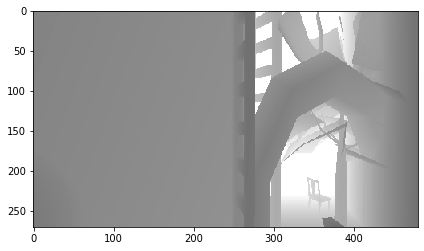

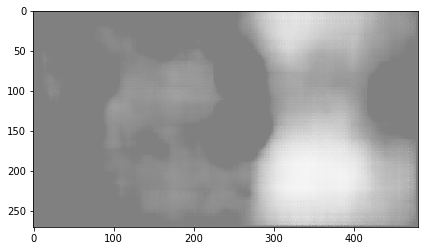

i: 46
tensor(0.4852) tensor(0.6355)
tensor(0.1149) tensor(0.0363)
torch.Size([32, 1, 270, 480])


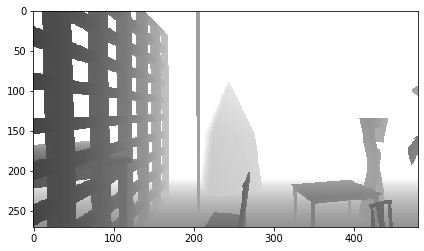

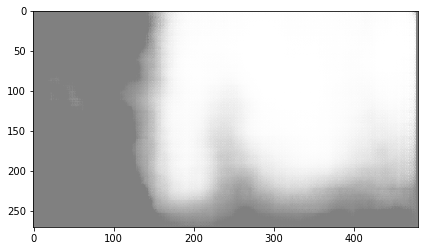

i: 47
tensor(0.4881) tensor(0.6343)
tensor(0.1106) tensor(0.0361)
torch.Size([32, 1, 270, 480])


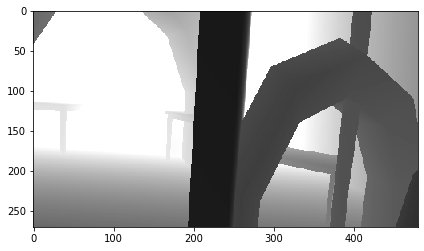

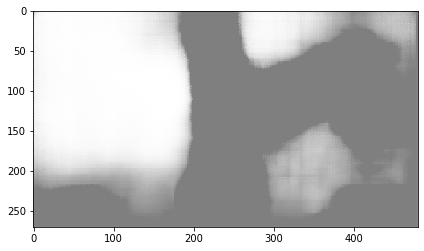

i: 48
tensor(0.5337) tensor(0.6641)
tensor(0.1233) tensor(0.0409)
torch.Size([32, 1, 270, 480])


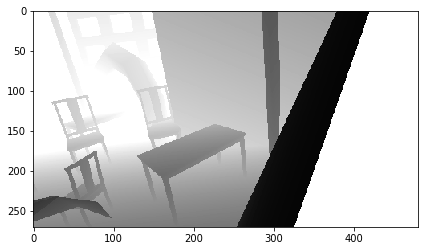

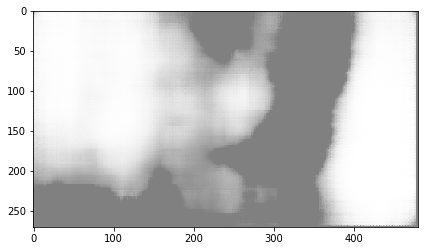

i: 49
tensor(0.4643) tensor(0.6166)
tensor(0.1019) tensor(0.0319)
torch.Size([32, 1, 270, 480])


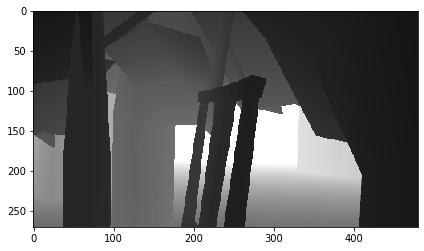

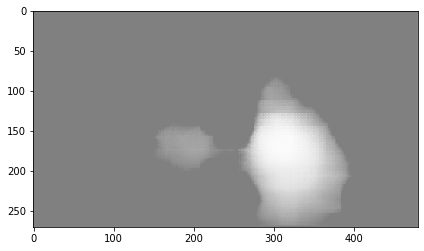

i: 50
tensor(0.5301) tensor(0.6632)
tensor(0.1231) tensor(0.0433)
torch.Size([32, 1, 270, 480])


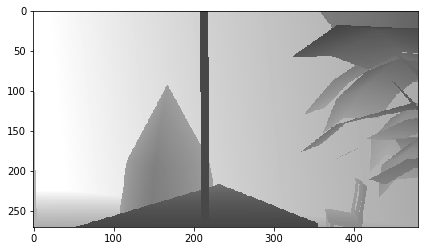

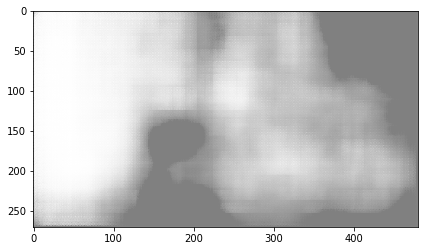

i: 51
tensor(0.4612) tensor(0.6275)
tensor(0.1183) tensor(0.0350)
torch.Size([32, 1, 270, 480])


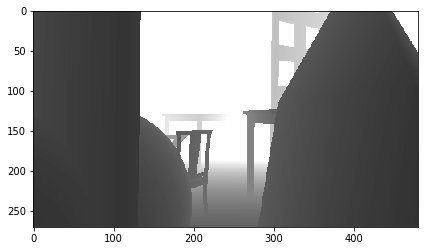

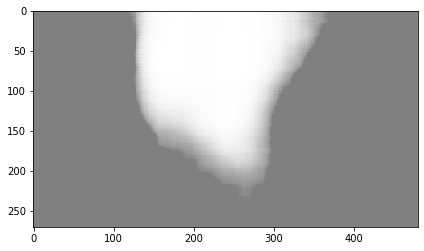

i: 52
tensor(0.4931) tensor(0.6236)
tensor(0.0968) tensor(0.0332)
torch.Size([32, 1, 270, 480])


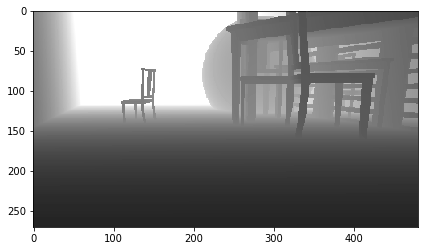

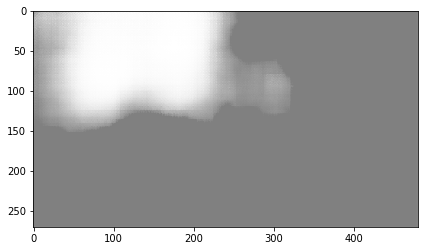

i: 53
tensor(0.5118) tensor(0.6546)
tensor(0.1248) tensor(0.0409)
torch.Size([32, 1, 270, 480])


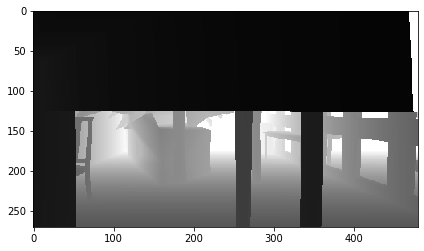

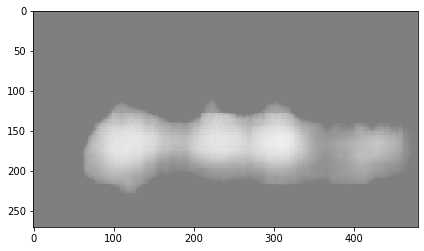

i: 54
tensor(0.5381) tensor(0.6600)
tensor(0.1144) tensor(0.0405)
torch.Size([32, 1, 270, 480])


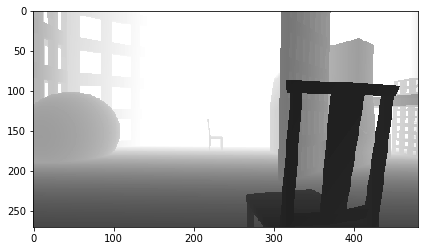

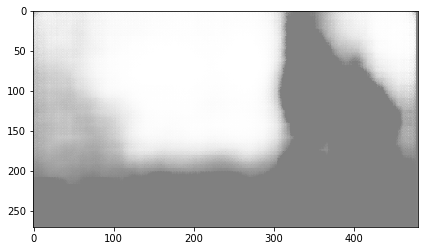

i: 55
tensor(0.4960) tensor(0.6458)
tensor(0.1216) tensor(0.0390)
torch.Size([32, 1, 270, 480])


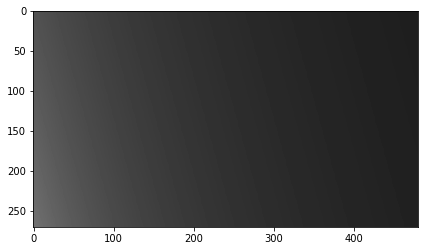

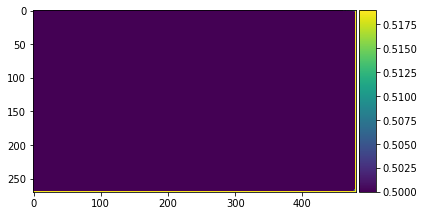

i: 56
tensor(0.5190) tensor(0.6449)
tensor(0.1067) tensor(0.0380)
torch.Size([32, 1, 270, 480])


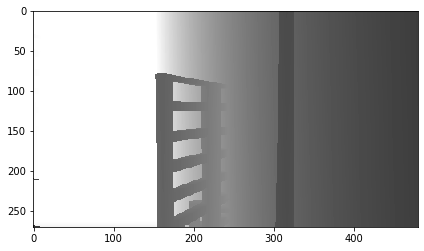

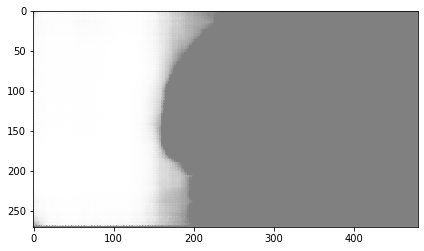

i: 57
tensor(0.5091) tensor(0.6445)
tensor(0.1170) tensor(0.0400)
torch.Size([32, 1, 270, 480])


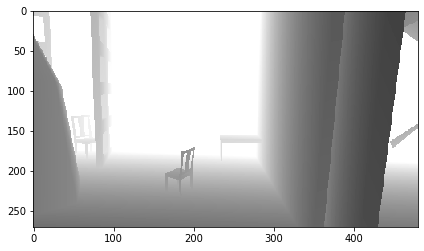

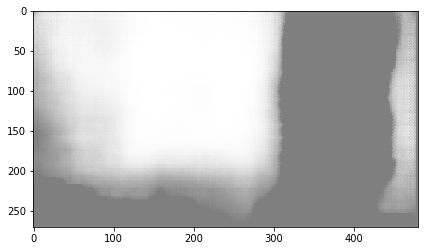

i: 58
tensor(0.5457) tensor(0.6647)
tensor(0.1099) tensor(0.0403)
torch.Size([32, 1, 270, 480])


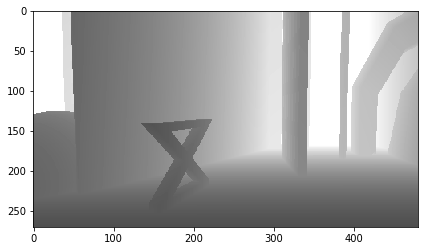

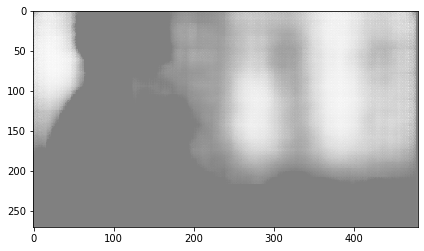

i: 59
tensor(0.5521) tensor(0.6687)
tensor(0.1156) tensor(0.0412)
torch.Size([32, 1, 270, 480])


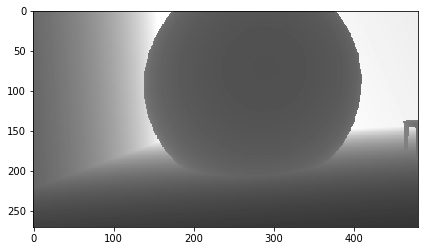

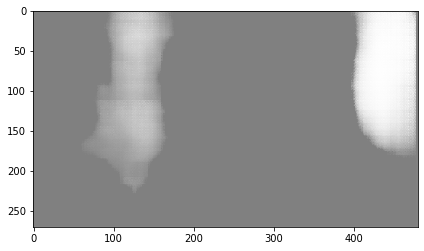

i: 60
tensor(0.4623) tensor(0.6201)
tensor(0.1081) tensor(0.0337)
torch.Size([32, 1, 270, 480])


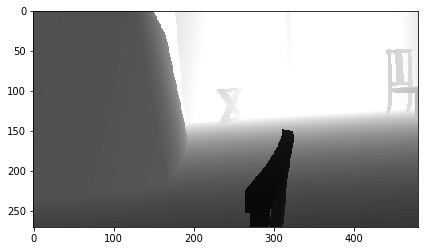

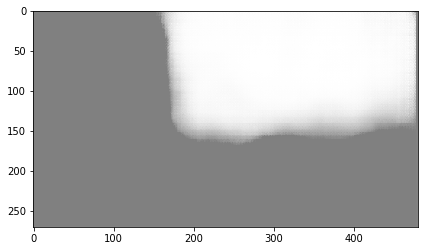

i: 61
tensor(0.4898) tensor(0.6277)
tensor(0.1053) tensor(0.0344)
torch.Size([32, 1, 270, 480])


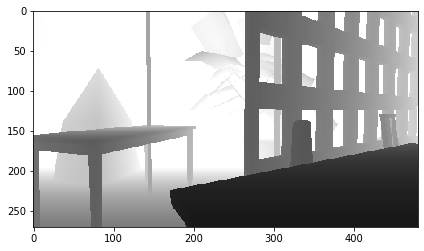

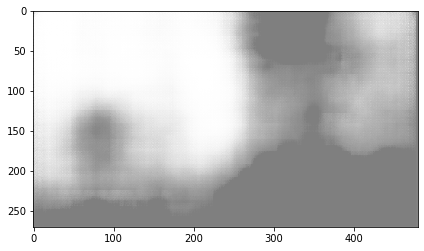

i: 62
tensor(0.4916) tensor(0.6342)
tensor(0.1107) tensor(0.0365)
torch.Size([32, 1, 270, 480])


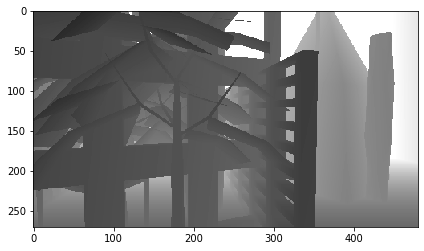

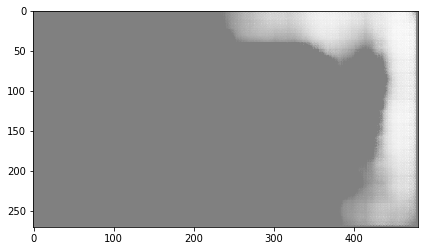

i: 63
tensor(0.5067) tensor(0.6418)
tensor(0.1154) tensor(0.0388)
torch.Size([32, 1, 270, 480])


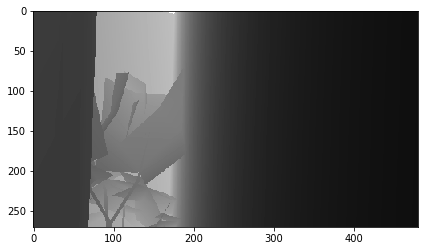

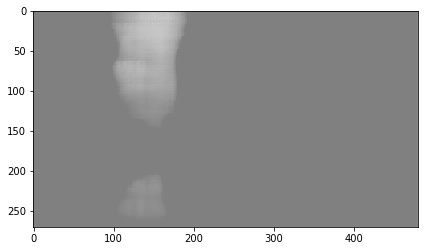

i: 64
tensor(0.4257) tensor(0.6135)
tensor(0.1193) tensor(0.0360)
torch.Size([32, 1, 270, 480])


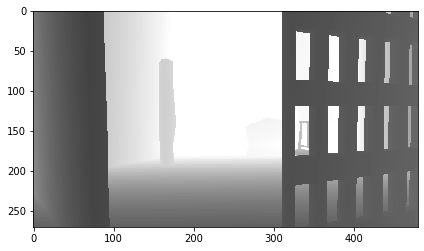

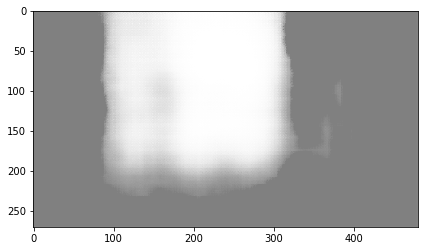

i: 65
tensor(0.4749) tensor(0.6352)
tensor(0.1208) tensor(0.0368)
torch.Size([32, 1, 270, 480])


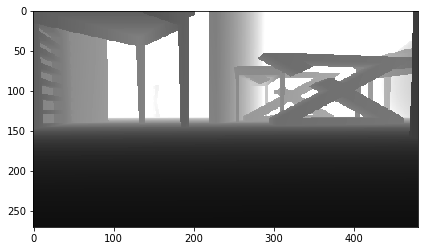

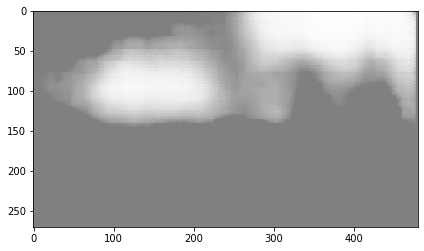

i: 66
tensor(0.4113) tensor(0.5993)
tensor(0.1048) tensor(0.0285)
torch.Size([32, 1, 270, 480])


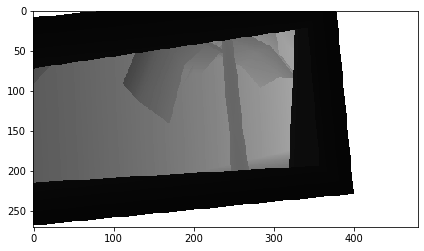

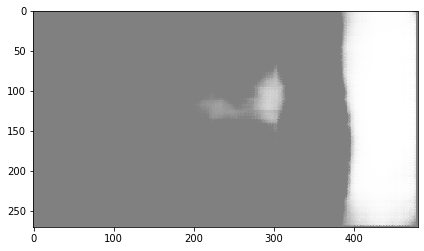

i: 67
tensor(0.4868) tensor(0.6280)
tensor(0.0999) tensor(0.0343)
torch.Size([32, 1, 270, 480])


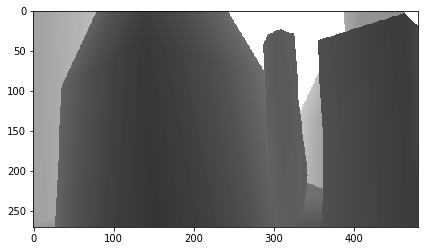

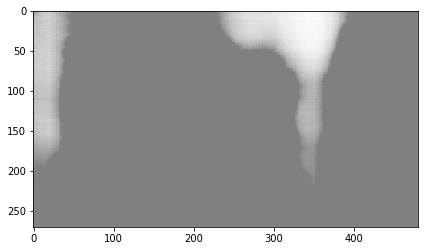

i: 68
tensor(0.4902) tensor(0.6492)
tensor(0.1296) tensor(0.0393)
torch.Size([32, 1, 270, 480])


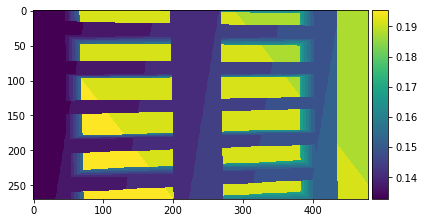

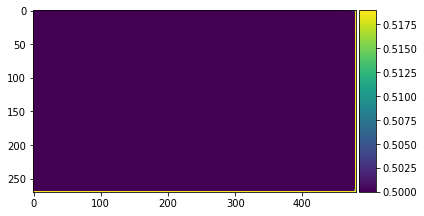

i: 69
tensor(0.5279) tensor(0.6486)
tensor(0.1078) tensor(0.0410)
torch.Size([10, 1, 270, 480])


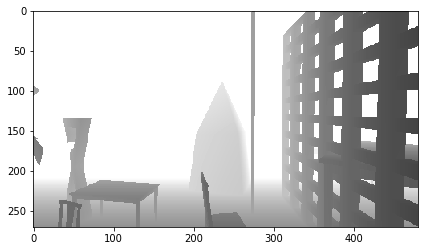

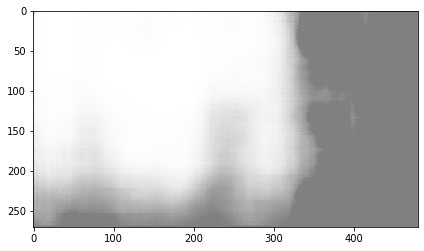

i: 70


In [21]:
vae_model.eval()
# Visualise sample of images

with torch.no_grad():
    for i, (images, *_) in enumerate(test_loader):
        # VAE forward pass
        _, _, x_hat = vae_model(images)

        print(images.mean(), x_hat.mean())
        print(images.var(), x_hat.var())
        print(images.shape)
        for idx in range(1):
            # show images
            imshow(images[idx])
            imshow(x_hat[idx])

        # write to tensorboard
        # writer.add_image('four_cifar10_images', inv_normalize(img_grid))
        print(f"i: {i}")


## Training set

In [22]:
vae_model.eval()
# Visualise sample of images
with torch.no_grad():
    for images in train_loader:
        # VAE forward pass
        _, _, x_hat = vae_model(images)

        print(images.mean(), x_hat.mean())
        print(images.var(), x_hat.var())
        print(images.shape)
        for idx in range(1):
            # show images
            imshow(images[idx])
            imshow(x_hat[idx])
